In [1]:
import geopandas
import matplotlib.pyplot as plt
import overpass
import numpy as np
import pandas as pd

In [2]:
def make_feature_dict(df, features, prefix=None):
    """
    
    Parameters
    ----------
    df : geopandas.geodataframe.GeoDataFrame
        Dataframe containing features pulled from overpass API
        
    features : list
        List of column names associated with high-level feature names
        employed by overpass/OSM. Reference here:
        https://wiki.openstreetmap.org/wiki/Map_Features
        
    prefix : str
        Additional identifier placed before feature name.
        
    Returns
    -------
    dict
        Nested dictionary of features with value counts as eventual values.
        
    """
    
    if prefix!=None:
        pass
    else:
        prefix=''
        
    feature_dict = {}
    for feature in features:
        if feature in df.columns:
            series = df[feature].value_counts()
            feature_dict[prefix+feature] = { k:v for (k,v) in zip(series.index, series.values)}
        else:
            feature_dict[prefix+feature] = None
    return feature_dict

## Load collision line segments

In [14]:
collision_per_aadt = geopandas.read_file('test_geometries.shp')

In [58]:
collision_null = geopandas.read_file('no_crash_geometries_191001.shp')

In [15]:
collision_per_aadt.shape

(1506, 2)

In [19]:
collision_per_aadt.columns

Index(['collision_', 'geometry'], dtype='object')

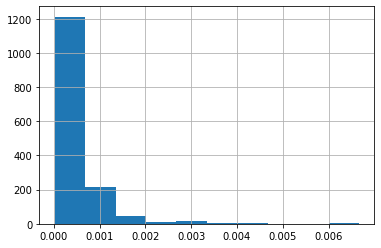

In [20]:
collision_per_aadt.collision_.hist()

## Make buffer polygons from line segments

25
6
33
8


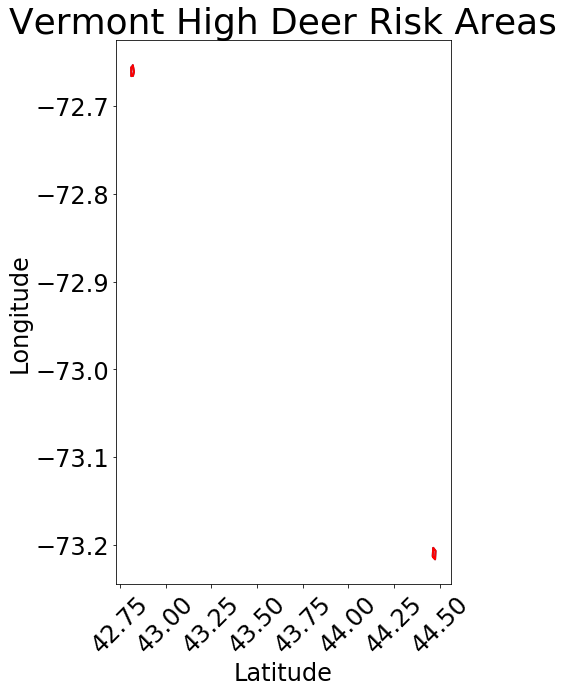

In [22]:
colors = plt.get_cmap('tab20b') #, lut=test.normal_aadt.max())
plt.figure(figsize=(3*2,5*2))

for index, row in collision_per_aadt.iloc[:2,:].iterrows(): 
    poly = row.geometry.buffer(.005, cap_style=3)
    test_shape = poly.simplify(0.001, preserve_topology=False)
    print(len(poly.exterior.coords))
    print(len(test_shape.exterior.coords))
    y, x = poly.exterior.xy
    plt.plot(x, y, 
             color=colors(row.collision_),
             lw=2, alpha=1)
    
    y, x = test_shape.exterior.xy
    plt.plot(x, y, 
             color='red',
             lw=2, alpha=1)

plt.xlabel('Latitude', fontsize=24)
plt.ylabel('Longitude', fontsize=24)
plt.title('Vermont High Deer Risk Areas', fontsize=36)
plt.xticks(fontsize=24, rotation=45)
plt.yticks(fontsize=24)
None

## Building the `overpass` road query from the midpoint

In [23]:
api_pass = overpass.API(timeout=600)

In [24]:
road_query = 'nwr(around:1, {c[0]}, {c[1]});(._;>;);out;'.format(
    c=row.geometry.interpolate(0.5, normalized = True).coords[:][0])

In [25]:
road_query

'nwr(around:1, -72.66073492384002, 42.81768648415323);(._;>;);out;'

In [26]:
#road_query = 'way[highway](around:5,44.15349716748267, -72.49253549908933);(._;>;);out meta;'
#road_query = 'nwr(around:5,44.15349716748267, -72.49253549908933);(._;>;);out;'

road_response = api_pass.get(road_query)

In [27]:
road_geodf = geopandas.GeoDataFrame.from_features(road_response)
culled_road = road_geodf.dropna(axis='index', how='all', subset=road_geodf.columns[1:])

In [28]:
make_feature_dict(culled_road, ['highway', 'surface'], prefix=None)

{'highway': None, 'surface': None}

## Building the `overpass` area query from the simplified polygon

In [37]:
area_query = 'nwr(poly:"{}");out;'.format(
            ' '.join('{c[1]} {c[0]}'.format(c=c) for c in test_shape.exterior.coords[:]))

In [38]:
area_query

'nwr(poly:"42.816272103515374 -72.6655837116834 42.82115274296166 -72.66513108246374 42.82623915025208 -72.66091713215206 42.819618540552426 -72.65342263235522 42.81713645668685 -72.65561529483587 42.81077738062425 -72.65595723066521 42.811503391164315 -72.66593084128 42.816272103515374 -72.6655837116834");out;'

## Querying `overpass` with area polygon

In [39]:
"""
area_query = 'nwr(poly:"44.21942752883122 -72.56043380096837 44.229099324639975 -72.5561157214792 44.23530459506124 -72.55586883955655 \
                     44.237015175914344 -72.55395429014412 44.24820086817967 -72.56394830277897 44.240305872836885 -72.57175694223717 \
                     44.23556179577818 -72.57255065310554 44.23162010716889 -72.57106247361077 44.219529508340614 -72.57718734499564 \
                     44.21276642403039 -72.56379851791435 44.21942752883122 -72.56043380096837");out;'
"""

response = api_pass.get(area_query)

## Feeding `overpass` area query into `geopandas`

In [40]:
geodf = geopandas.GeoDataFrame.from_features(response)
culled_geodf = geodf.dropna(axis='index', how='all', subset=geodf.columns[1:])

## Populate feature dictionary from `GeoDataFrame`

In [41]:
cols = [
    'aeroway',
    'amenity',
    'barrier',
    'boundary',
    'building',
    'healthcare',
    'highway',
    'landuse',
    'leisure',
    'man_made',
    'natural',
    'parking',
    'power',
    'railway',
    'route',
    'service',
    'surface',
    'tourism',
    'waterway'
]

In [42]:
feature_dict = make_feature_dict(culled_road, ['highway', 'surface'], prefix='road_')

In [43]:
feature_dict

{'road_highway': None, 'road_surface': None}

In [44]:
feature_dict.update(make_feature_dict(culled_geodf, cols, prefix='area_'))

In [45]:
feature_dict

{'road_highway': None,
 'road_surface': None,
 'area_aeroway': None,
 'area_amenity': None,
 'area_barrier': None,
 'area_boundary': None,
 'area_building': {'residential': 2, 'farm_auxiliary': 2},
 'area_healthcare': None,
 'area_highway': {'track': 12, 'residential': 8, 'path': 2, 'service': 2},
 'area_landuse': {'farmyard': 6},
 'area_leisure': None,
 'area_man_made': None,
 'area_natural': {'water': 4},
 'area_parking': None,
 'area_power': None,
 'area_railway': None,
 'area_route': None,
 'area_service': None,
 'area_surface': {'asphalt': 2, 'gravel': 2},
 'area_tourism': None,
 'area_waterway': None}

# Combining everything in a massive `for` loop

In [46]:
import time

In [51]:
collision_per_aadt.head()

,collision_,geometry
0,0.000345,LINESTRING (-73.20970418741922 44.467297895026...
1,0.000435,LINESTRING (-72.66058103070257 42.816127191201...
2,0.000260,LINESTRING (-72.30824588902144 43.713538389200...
3,0.000119,LINESTRING (-72.5741598849302 44.2142368414836...
4,0.000068,LINESTRING (-73.00411822391678 43.604181401677...


In [54]:
.0075/2

0.00375

In [59]:
collision_null.head()

,collision,geometry
0,0,LINESTRING (-73.24669951623491 42.932856072407...
1,0,LINESTRING (-72.48893448048413 44.268323924481...
2,0,LINESTRING (-73.10310734049173 44.095951832437...
3,0,LINESTRING (-72.64764585022782 43.848127019860...
4,0,LINESTRING (-73.00687878304478 44.951906736297...


```python
endpoint = 'https://overpass.kumi.systems/api/interpreter'
endpoint = 'https://z.overpass-api.de/api/interpreter'
endpoint = 'https://lz4.overpass-api.de/api/interpreter'
api_pass = overpass.API(timeout=7200, endpoint=endpoint)
road_responses, area_responses = list(), list()
i = 0

for index, row in collision_null.iloc[i:,:].iterrows(): 
    print(i, end=', ')
    poly = row.geometry.buffer(.00375, cap_style=3)
    test_shape = poly.simplify(0.001, preserve_topology=False)
    
    # Building overpass queries
    road_query = 'nwr(around:1, {c[1]}, {c[0]});(._;>;);out;'.format(
        c=row.geometry.interpolate(0.5, normalized = True).coords[:][0])
    area_query = 'nwr(poly:"{}");out;'.format(
        ' '.join('{c[1]} {c[0]}'.format(c=c) for c in test_shape.exterior.coords[:]))
    
    # Getting overpass road responses
    road_response = api_pass.get(road_query)
    #road_responses.append(road_response)
    road_geodf = geopandas.GeoDataFrame.from_features(road_response)
    culled_road = road_geodf.dropna(axis='index', how='all', subset=road_geodf.columns[1:])
    # Overwriting feature_dict each time
    feature_dict = make_feature_dict(culled_road, ['highway', 'surface'], prefix='road_')
    time.sleep(1)
    
    # Getting overpass area responses
    response = api_pass.get(area_query)
    #area_responses.append(response)
    geodf = geopandas.GeoDataFrame.from_features(response)
    culled_geodf = geodf.dropna(axis='index', how='all', subset=geodf.columns[1:])
    feature_dict.update(make_feature_dict(culled_geodf, cols, prefix='area_'))
    pd.io.json.json_normalize(feature_dict).to_csv('overpass_short_segments_191001/no_crashes/{}.csv'.format(str(i).rjust(4,'0')))
    time.sleep(1)
    i += 1
```

# Writing code for the web app:

```python
feature_df_list = [pd.read_csv('dummy_features.csv')]
for line in line_list:
    poly = line.geometry.buffer(.0025, cap_style=3)
    simplified = poly.simplify(0.001, preserve_topology=False)
    
    # Building overpass queries
    road_query = 'nwr(around:1, {c[0]}, {c[1]});(._;>;);out;'.format(
        c=line.geometry.interpolate(0.5, normalized = True).coords[:][0])
    area_query = 'nwr(poly:"{}");out;'.format(
        ' '.join('{c[0]} {c[1]}'.format(c=c) for c in simplified.exterior.coords[:]))
    
    # Getting overpass road responses
    road_response = api_pass.get(road_query)
    road_geodf = geopandas.GeoDataFrame.from_features(road_response)
    culled_road = road_geodf.dropna(axis='index', how='all', subset=road_geodf.columns[1:])
    # Overwriting feature_dict each time
    feature_dict = make_feature_dict(culled_road, ['highway', 'surface'], prefix='road_')
    time.sleep(1)
    
    # Getting overpass area responses
    response = api_pass.get(area_query)
    geodf = geopandas.GeoDataFrame.from_features(response)
    culled_geodf = geodf.dropna(axis='index', how='all', subset=geodf.columns[1:])
    feature_dict.update(make_feature_dict(culled_geodf, cols, prefix='area_'))
    feature_df_list.append(pd.io.json.json_normalize(feature_dict))
    time.sleep(1)
    
```

In [103]:
collision_per_aadt.shape

(1099, 2)

In [41]:
# Note these columns have 3 rows of values:
original = pd.DataFrame({
    'Age':[10, 12, 13]})

# Note this column has 4 rows of values:
additional = pd.DataFrame({
    'Name': ['Nate A', 'Jessie A', 'Daniel H', 'John D']
})

new = pd.concat([original, additional], axis=1) 
# Identical:
# new = pandas.concat([original, additional], ignore_index=False, axis=1) 

print(new.head())

    Age      Name
0  10.0    Nate A
1  12.0  Jessie A
2  13.0  Daniel H
3   NaN    John D


In [42]:
original

,Age
0,10
1,12
2,13


In [43]:
additional

,Name
0,Nate A
1,Jessie A
2,Daniel H
3,John D


In [61]:
row_1097 = pd.read_csv('overpass_data/{}.csv'.format(str(1097).rjust(4,'0')))
row_1098 = pd.read_csv('overpass_data/{}.csv'.format(str(1098).rjust(4,'0')))
row_0001 = pd.read_csv('overpass_data/{}.csv'.format(str(1).rjust(4,'0')))

In [62]:
_df_test = pd.concat([row_0001, row_1097, row_1098], axis=0, sort=True)

In [63]:
_df_test

,Unnamed: 0,area_aeroway,area_amenity,area_amenity.bank,area_amenity.hospital,area_amenity.parking,area_amenity.restaurant,area_barrier,area_barrier.gate,area_boundary,...,area_waterway,area_waterway.river,area_waterway.stream,road_highway,road_highway.crossing,road_highway.secondary,road_highway.tertiary,road_highway.traffic_signals,road_surface,road_surface.asphalt
0,0,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,NaN,2.0,NaN,NaN,2.0
0,0,NaN,NaN,2.0,NaN,NaN,4.0,NaN,2.0,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,16.0,NaN,2.0,NaN,16.0


In [ ]:
df_list
for i in range(collision_per_aadt.shape[0]):
    new_row = pd.read_csv('overpass_data/{}.csv'.format(str(i).rjust(4,'0')))

In [65]:
len(df_list)

50

In [17]:
for i in range(collision_per_aadt.shape[0]):
    new_row = pd.read_csv('overpass_data/{}.csv'.format(str(i).rjust(4,'0')))
    if i==0:
        df = new_row
    else:
        df = df.iloc[:,1:].merge(new_row.iloc[:,1:], how='outer')

In [35]:
type(new_row)

pandas.core.frame.DataFrame

In [39]:
new_row.columns

Index(['Unnamed: 0', 'area_aeroway', 'area_amenity', 'area_barrier',
       'area_boundary', 'area_healthcare', 'area_leisure', 'area_man_made',
       'area_natural', 'area_parking', 'area_power', 'area_railway',
       'area_route', 'area_tourism', 'area_waterway', 'road_highway.secondary',
       'road_highway.traffic_signals', 'road_highway.crossing',
       'road_surface.asphalt', 'area_building.yes', 'area_building.roof',
       'area_building.commercial', 'area_highway.service',
       'area_highway.motorway', 'area_highway.primary',
       'area_highway.motorway_link', 'area_highway.secondary',
       'area_highway.primary_link', 'area_highway.unclassified',
       'area_highway.traffic_signals', 'area_landuse.retail',
       'area_service.drive-through', 'area_surface.asphalt'],
      dtype='object')

In [18]:
df.shape

(1099, 235)

In [19]:
df['normal_aadt'] = collision_per_aadt.normal_aad

In [20]:
df.shape

(1099, 236)

In [21]:
df.head()

,area_natural.sand,area_building.barn,area_leisure.garden,area_railway.rail,area_tourism.motel,area_amenity.courthouse,area_natural.peak,area_amenity.hospital,area_highway.footway,road_highway.stop,...,area_leisure.slipway,area_natural.wetland,area_tourism.viewpoint,area_barrier,area_amenity.post_office,area_amenity,road_highway.crossing,area_highway.primary,area_service.drive-through,normal_aadt
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.017230
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019030
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.085000
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.035417
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.021983


In [122]:
df.to_csv("vt_overpass_features_plus_target_aadt_190926.csv", index=False)

In [23]:
df_zeros = df.fillna(0)

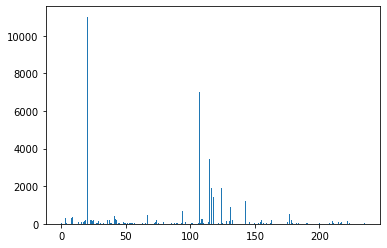

In [24]:
plt.bar(range(len(df_zeros.sum().index)), df_zeros.sum().values)
None

In [111]:
for index, value in df_zeros.sum().items():
    print("{} : {}".format(index, value))

area_natural.sand : 18.0
area_building.barn : 14.0
area_leisure.garden : 4.0
area_railway.rail : 320.0
area_tourism.motel : 20.0
area_amenity.courthouse : 2.0
area_natural.peak : 6.0
area_amenity.hospital : 6.0
area_highway.footway : 298.0
road_highway.stop : 352.0
area_barrier.border_control : 2.0
area_healthcare : 0.0
area_amenity.atm : 2.0
area_amenity.fire_station : 72.0
area_amenity.childcare : 2.0
area_amenity.shelter : 12.0
area_power.pole : 80.0
area_leisure.park : 116.0
area_highway.track : 168.0
area_leisure.pitch : 198.0
road_highway.primary : 11020.0
area_aeroway.aerodrome : 4.0
area_amenity.kindergarten : 4.0
area_highway.path : 176.0
area_highway.traffic_signals : 142.0
road_surface.paved : 222.0
area_highway.road : 4.0
area_building.residential : 22.0
area_building.garage : 18.0
area_highway.crossing : 142.0
area_highway.stop : 48.0
area_leisure.picnic_table : 8.0
area_surface.ground : 10.0
road_highway.secondary_link : 22.0
area_landuse.basin : 10.0
area_building.railwa

# **THIS IS THE REAL SHIT HERE**

In [80]:
df_list = list()
for i in range(collision_per_aadt.shape[0]):
    if i==0:
        df = pd.read_csv('overpass_data/{}.csv'.format(str(i).rjust(4,'0')))
    df_list.append(pd.read_csv('overpass_data/{}.csv'.format(str(i).rjust(4,'0'))))

In [81]:
test = pd.concat(df_list, sort=True)
test.reset_index(inplace=True)

In [103]:
test.shape

(1099, 415)

In [105]:
collision_per_aadt.head()

,normal_aad,geometry
0,0.017230,LINESTRING (44.15173777688162 -72.492244939151...
1,0.019030,LINESTRING (44.23761101572958 -72.564544142594...
2,0.085000,LINESTRING (44.15899228768008 -72.451809285104...
3,0.035417,LINESTRING (42.93774081787448 -73.251840860970...
4,0.021983,LINESTRING (44.46729789502609 -73.209704187419...


In [106]:
test['normal_aadt'] = collision_per_aadt.normal_aad

In [114]:
test.columns

Index(['index', 'Unnamed: 0', 'area_aeroway', 'area_aeroway.aerodrome',
       'area_aeroway.apron', 'area_aeroway.helipad',
       'area_aeroway.holding_position', 'area_aeroway.navigationaid',
       'area_aeroway.runway', 'area_aeroway.taxiway',
       ...
       'road_surface.dirt', 'road_surface.earth', 'road_surface.grass',
       'road_surface.gravel', 'road_surface.ground', 'road_surface.paved',
       'road_surface.sand', 'road_surface.unpaved', 'road_surface.wood',
       'normal_aadt'],
      dtype='object', length=416)

In [115]:
test.drop(['index', 'Unnamed: 0'], axis=1, inplace=True)

In [122]:
test.shape

(1099, 414)

In [123]:
test.dropna(axis=1, how='all', inplace=True)

In [124]:
test.shape

(1099, 394)

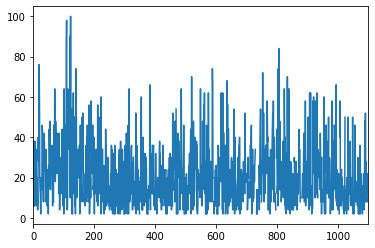

In [125]:
test['area_highway.residential'].plot()

```python
test.to_csv('vt_overpass_features_plus_target_aadt_CORRECTED_190926.csv', index=False)
```

In [101]:
for index, count in test.sum().sort_values().items():
    if count > 10000:
        print(index, count)

road_highway.crossing 14932.0
area_highway.service 15116.0
area_building.yes 16272.0
area_highway.residential 22408.0
road_highway.traffic_signals 22560.0
area_surface.asphalt 24134.0
road_highway.secondary 26110.0
road_highway.motorway 30270.0
road_highway.trunk 33212.0
road_highway.primary 100362.0
road_surface.asphalt 155086.0


# **THE REAL SHIT IS RIGHT ABOVE HERE**

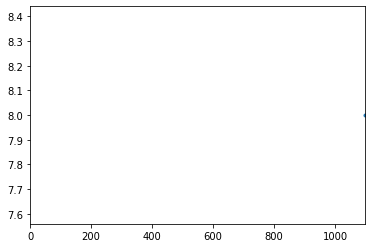

In [40]:
df['area_highway.primary'].plot(marker='.')

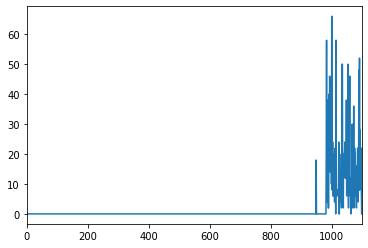

In [25]:
df_zeros['area_highway.residential'].plot()

In [9]:
test['area_highway.residential'].value_counts()

14    1
28    1
Name: area_highway.residential, dtype: int64

In [84]:
df = pd.DataFrame(np.random.randint(0, 2, (10, 4)), columns=list('abcd'))
df.apply(pd.Series.value_counts)

,a,b,c,d
0,3,6,5,5
1,7,4,5,5


In [85]:
df

,a,b,c,d
0,1,0,1,0
1,1,1,0,1
2,1,0,1,1
3,0,0,1,1
4,1,1,0,0
5,1,1,0,0
6,0,1,1,1
7,1,0,1,0
8,1,0,0,0
9,0,0,0,1


In [78]:
df_list[1]

,Unnamed: 0,area_aeroway,area_barrier,area_leisure,area_man_made,area_parking,area_railway,area_route,area_tourism,road_highway.tertiary,...,area_landuse.residential,area_natural.wood,area_natural.water,area_power.tower,area_power.line,area_service.driveway,area_surface.asphalt,area_surface.paved,area_surface.unpaved,area_waterway.stream
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,...,2,4,2,6,2,2,18,2,2,4


In [ ]:
pd.io.json.json_normalize(feature_dict).to_csv('overpass_data/{}.csv'.format(str(i).rjust(4,'0')))

In [45]:
collision_per_aadt.geometry[1].length

0.016485944924031545

In [44]:
collision_per_aadt.geometry[2].length

0.0028456558111031203

In [58]:
#from pandas.io.json import json_normalize
pd.io.json.json_normalize(feature_dict)

,area_aeroway,area_barrier,area_leisure,area_man_made,area_parking,area_railway,area_route,area_tourism,road_highway.tertiary,road_surface.asphalt,...,area_power.tower,area_power.pole,area_power.line,area_power.minor_line,area_service.parking_aisle,area_service.driveway,area_surface.asphalt,area_surface.paved,area_surface.unpaved,area_waterway.stream
0,None,None,None,None,None,None,None,None,2,2,...,12,4,4,2,10,4,52,2,2,4


In [72]:
pd.read_csv('test.csv')

,Unnamed: 0,area_aeroway,area_barrier,area_leisure,area_man_made,area_parking,area_railway,area_route,area_tourism,road_highway.tertiary,...,area_power.tower,area_power.pole,area_power.line,area_power.minor_line,area_service.parking_aisle,area_service.driveway,area_surface.asphalt,area_surface.paved,area_surface.unpaved,area_waterway.stream
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,...,12,4,4,2,10,4,52,2,2,4
